# Jigsaw Global Grid Prototype

This is the prototype for creating a bathymery weighted global grid. It emulates meshdemo 5 from jigsaw-geo-matlab repo.

In [1]:
#to use the full width of the browser window uncomment the code below and execute the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gp
import xarray as xr
from pyPoseidon.dem import erdap, gebco
from pyPoseidon.meteo import gfs_erdap
import glob
import os

In [2]:
import matplotlib

In [3]:
import subprocess

In [4]:
#%matplotlib notebook

## geo file

In [5]:
fgeo='/Users/brey/Downloads/JIGSAW/geo/EARTH-ARCTIC-GEOM.msh'

In [6]:
# write header
with open(fgeo,'w') as f:
    f.write('#{}; created by pyPoseidon\n'.format(fgeo.split('/')[-1]))
    f.write('MSHID=3;ELLIPSOID-MESH\n')
    f.write('RADII={};{};{}\n'.format(6371.000000,6371.000000,6371.000000))

## hfun file

### read bathymetry file

In [7]:
fbath = '/Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/geo/topo.msh'

In [8]:
coord, nc = pd.read_csv(fbath,header=2,skiprows=1,nrows=0,delimiter='=')
coord, nc

('COORD', '1;1201')

In [9]:
nc0, nc1 = nc.split(';')
nlon = int(nc1)

In [10]:
#read lon for all boundary nodes
xb = pd.read_csv(fbath,skiprows=4,header=None,nrows=nlon,names=['lon'])

In [11]:
coord, nc = pd.read_csv(fbath,header=4,skiprows=nlon,nrows=0,delimiter='=')
coord, nc

('COORD', '2;601')

In [12]:
nc0, nc2 = nc.split(';')
nlat = int(nc2)

In [13]:
#read lat,depth for boundary nodes
yb = pd.read_csv(fbath,skiprows=5 + nlon,header=None,nrows=nlat,names=['lat'])

In [14]:
value, nc = pd.read_csv(fbath,header=4,skiprows=nlon+nlat+1,nrows=0,delimiter='=')
value, nc

('VALUE', '721801;1')

In [15]:
val, val0 = nc.split(';')
val = int(val)

In [16]:
#read 
bath = pd.read_csv(fbath,skiprows=6 + nlon + nlat,header=None,nrows=val,names=['value'])

In [17]:
bath.head()

,value
0,2773
1,2806
2,2911
3,2993
4,3062


In [18]:
bath.tail()

,value
721796,-997
721797,-2408
721798,-3649
721799,-4139
721800,-4120


In [19]:
vb = bath.values.reshape(nlon,nlat)

In [20]:
vb.shape

(1201, 601)

In [21]:
zlev=vb.T # to match the matlab configuration in which the file fbath was saved on

In [22]:
vb.min(), vb.max()

(-10188, 7016)

In [23]:
X, Y = np.meshgrid(xb,yb)

In [24]:
X.shape

(601, 1201)

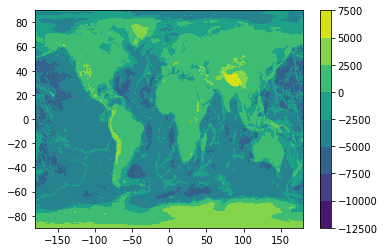

In [25]:
### plot
plt.figure()
plt.contourf(X,Y,zlev)
plt.colorbar()

### Scale

In [26]:
eps = np.finfo(float).eps

In [27]:
radE = 6371.0E+00 
      
hfn0 = +100. ;                      # global spacing
hfn2 = +20.;                        # adapt. spacing

 
dhdx = +.10;                        # max. gradients    

In [28]:
hfun = hfn0*np.ones([nlat,nlon]) # not the shape!

In [29]:
hfun.shape, zlev.shape

((601, 1201), (601, 1201))

In [30]:
b=zlev.copy() # make a copy so that we don't change zlev

b[b>0] = eps #normalize to only negative values

htop = np.sqrt(-b)/1.5 # scale with sqrt(H)

In [31]:
htop.min(), htop.max(), htop.mean()

(0.0, 67.29041536504289, 24.217953051263322)

In [32]:
htop[htop<hfn2] = hfn2 # normalize

In [33]:
htop.min(), htop.max(), htop.mean()

(20.0, 67.29041536504289, 32.152711710068566)

In [38]:
## optional focused area
hfn3 = +50.;                        # arctic spacing
htop[htop>hfn3] = hfn3

In [39]:
htop.min(), htop.max(), htop.mean()

(20.0, 50.0, 42.33443661652621)

In [40]:
htop[zlev>0.] = hfn0 

In [41]:
htop.min(), htop.max(), htop.mean()

(20.0, 100.0, 59.35373972084445)

In [42]:
hfun[Y>+50.] = htop[Y>+50.] # with focused area
#hfun = htop # global

In [43]:
hfun.min(), hfun.max(), hfun.mean()

(20.0, 100.0, 90.74276436606519)

In [44]:
#hfun = hfun.flatten() # make it 1-d

In [45]:
#hfun = np.array([[hf] for hf in list(pfun)]) #convert it to the appropriate format for LIMHFN2 below

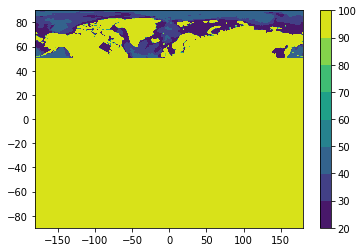

In [46]:
#plot
plt.figure()
plt.contourf(X,Y,hfun)
plt.colorbar()

## SPHGRID

In [95]:
ALON = X.T * np.pi / 180. 
ALAT = Y.T * np.pi / 180. 
    
#----------------------------------------- spheroidal coord.
xpos = radE * np.cos(ALON) * np.cos(ALAT) 
ypos = radE * np.sin(ALON) * np.cos(ALAT) 
zpos = radE * np.sin(ALAT)  

In [99]:
ALON.shape

(1201, 601)

In [100]:
ppos = pd.DataFrame({'a':xpos.flatten(),'b':ypos.flatten(), 'c':zpos.flatten()})

In [101]:
ppos[:5]

,a,b,c
0,-3.901112e-13,-4.777485e-29,-6371.000000
1,-3.335866e+01,-4.085258e-15,-6370.912666
2,-6.671551e+01,-8.170294e-15,-6370.650676
3,-1.000715e+02,-1.225523e-14,-6370.214022
4,-1.334238e+02,-1.633971e-14,-6369.602741


In [102]:
grid = np.arange(nlat*nlon).reshape(nlon,nlat)

In [103]:
grid = grid.T
grid.shape

(601, 1201)

In [104]:
grid[:,0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [105]:
quad = np.zeros([(nlat-1)*(nlon-0),4])

nex = 0
for jpos in range(1,nlat):
       
            quad[nex,0] = grid[jpos-1,nlon-1]
            quad[nex,1] = grid[jpos-1,0]
            quad[nex,2] = grid[jpos-0,0]
            quad[nex,3] = grid[jpos-0,nlon-1]
            
            nex = nex+1
            

        
for ipos in range(1,nlon):
    for jpos in range(1,nlat):
       
            quad[nex,0] = grid[jpos-1,ipos-1]
            quad[nex,1] = grid[jpos-1,ipos-0]
            quad[nex,2] = grid[jpos-0,ipos-0]
            quad[nex,3] = grid[jpos-0,ipos-1]
            
            nex = nex+1 
     

In [107]:
quad = quad.astype(int)

In [108]:
quad

array([[721200,      0,      1, 721201],
       [721201,      1,      2, 721202],
       [721202,      2,      3, 721203],
       ...,
       [721196, 721797, 721798, 721197],
       [721197, 721798, 721799, 721198],
       [721198, 721799, 721800, 721199]])

### LIMHFUN

In [109]:
edge = np.vstack([quad[:,[0,1]],
        quad[:,[1,2]],
        quad[:,[2,3]],
        quad[:,[3,0]]
           ])


In [110]:
edge


array([[721200,      0],
       [721201,      1],
       [721202,      2],
       ...,
       [721197, 721196],
       [721198, 721197],
       [721199, 721198]])

In [111]:
edge.shape

(2882400, 2)

In [112]:
edge.sort(axis=1)

In [113]:
edge

array([[     0, 721200],
       [     1, 721201],
       [     2, 721202],
       ...,
       [721196, 721197],
       [721197, 721198],
       [721198, 721199]])

In [114]:
edge = np.unique(edge,axis=0)

In [115]:
edge[:10]

array([[     0,      1],
       [     0,    601],
       [     0, 721200],
       [     1,      2],
       [     1,    602],
       [     1, 721201],
       [     2,      3],
       [     2,    603],
       [     2, 721202],
       [     3,      4]])

In [116]:
evec = ppos.values[edge[:,1],:] - ppos.values[edge[:,0],:] 

In [117]:
evec.shape

(1442401, 3)

In [118]:
elen = np.sqrt(np.sum(evec**2,axis=1))

In [119]:
elen[:10]

array([3.33587735e+01, 2.04261533e-15, 9.55496958e-29, 3.33578839e+01,
       1.74665331e-01, 8.17051503e-15, 3.33588847e+01, 3.49321217e-01,
       1.63405882e-14, 3.33578839e+01])

In [120]:
elen.min(), elen.max(), elen.mean()

(9.554969575338695e-29, 33.35955183293824, 27.26595404999472)

### LIMGRAD

In [123]:
def limgrad(edge,elen,ffun,dfdx,imax):
    
    rfun = ffun.T.flatten()
    
    rfun = np.array([[hf] for hf in list(rfun)])
    
    eps = np.finfo(float).eps
    
    nnod = rfun.size
        
    #-- IVEC(NPTR(II,1):NPTR(II,2)) are edges adj. to II-TH node
    nvec = np.hstack([edge[:,0], edge[:,1]])

    ivec = np.hstack([np.arange(edge.shape[0]),np.arange(edge.shape[0])])


    nvec_ = np.sort(nvec, kind='mergesort')
    pidx = np.argsort(nvec, kind='mergesort') # to match with matlab/octave -> https://stackoverflow.com/questions/39484073/matlab-sort-vs-numpy-argsort-how-to-match-results
    ivec = ivec[pidx]
    nvec = nvec_
    
    
    mark = np.full(rfun.size, False, dtype=bool)
    mark[edge[:,0]]=True
    mark[edge[:,1]]=True

    dif = [nvec[i+1]-nvec[i] for i in range(nvec.shape[0]-1)]
    idxx = np.argwhere(np.array(dif) > 0).flatten()
    
    nptr=np.zeros((mark.size,2))
    nptr[mark,0] = np.append(np.array([0]),idxx+1)
    nptr[mark,1] = np.append(idxx, nnod-1)
    
    nptr = nptr.astype(int)

#----------------------------- ASET=ITER if node is "active"
    aset = np.zeros(nnod)
    
    ftol = min(rfun.flatten()) * np.sqrt(eps)
    

#----------------------------- exhaustive 'til all satisfied 
    
    for i in range(1,imax):
    
    #------------------------- find "active" nodes this pass
        aidx = np.argwhere(aset == i - 1 ) 
        aidx = aidx.flatten()
        
        if not aidx.any(): break
      
    #------------------------- reorder => better convergence

        aval = np.sort(rfun.reshape(ffun.shape).flatten()[aidx],kind='mergesort')
        idxx = np.argsort(rfun.reshape(ffun.shape).flatten()[aidx], kind='mergesort')
        
        aidx = aidx[idxx]
       
    #%------------------------- visit adj. edges and set DFDX
        for ipos in range(len(aidx)):
            npos = aidx[ipos]
        
            for jpos in range(nptr[npos,0], nptr[npos,1]+1):
                
                epos = ivec[jpos]
                
                nod1 = edge[epos,0]
                nod2 = edge[epos,1]
                
               # print ipos, jpos, epos, nod1, nod2

            #----------------- calc. limits about min.-value
                if rfun[nod1] > rfun[nod2]:
                
                    
                    fun1 = rfun[nod2] + elen[epos] * dfdx 
                
                    if rfun[nod1] > fun1+ftol :
                        rfun[nod1] = fun1
                        aset[nod1] = i
                else:
                
                    fun2 = rfun[nod1] + elen[epos] * dfdx 
                    
                    if   rfun[nod2] > fun2+ftol :
                        rfun[nod2] = fun2
                        aset[nod2] = i
     
    flag = i < imax
    
    return rfun,flag

In [ ]:
#edge2 = pd.read_csv('/Users/brey/Desktop/edge',header=None).values

#edge2 = edge2 - 1

#elen2 = pd.read_csv('/Users/brey/Desktop/elen',header=None).values

#hfun2 = pd.read_csv('/Users/brey/Desktop/hfun0',header=None).values

#rfun2 = pd.read_csv('/Users/brey/Desktop/fun',header=None).values


#run it
#[rfun,flag] = limgrad(edge2,elen2,hfun2,dhdx,100)

#difference from the original hfun2
#dff = rfun.flatten().reshape(X.T.shape).T - hfun2.flatten().reshape(X.T.shape).T # note the transpose 

In [125]:
dhdx = .15

In [126]:
[fun,flag] = limgrad(edge,elen,hfun,dhdx,4096)

In [127]:
fun.min(), fun.max(), fun.mean()

(20.0, 100.0, 87.11213993149046)

In [130]:
fun[-100:]

array([[24.95840125],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [22.10676484],
       [24.16601245],
       [24.11831221],
       [22.03521498],
       [27.01506839],
       [31.99473387],
       [36.97449427],
       [41.95405145],
       [45.01882992],
       [40.01501389],
       [35.01133131],
       [30.00749861],
       [25.00381602],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [25.00368259],
       [23.19204835],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20.        ],
       [20

In [131]:
hfun.shape

(601, 1201)

In [150]:
tfun = fun.reshape(hfun.T.shape) # we use the transpose to get back to python

In [151]:
tfun.shape

(1201, 601)

In [152]:
tfun.min(), tfun.max(), tfun.mean()

(20.0, 100.0, 87.11213993149046)

In [154]:
#difference from the original hfun
dff = tfun - hfun.T

In [155]:
#difference between solutions (JIGSAW & This one)
#dff = fun.flatten().reshape(X.shape) - rfun.flatten().reshape(X.T.shape).T

In [156]:
dff.min(), dff.max(), dff.mean()

(-79.42488348673074, 0.0, -3.6306244345746856)

In [157]:
%matplotlib inline

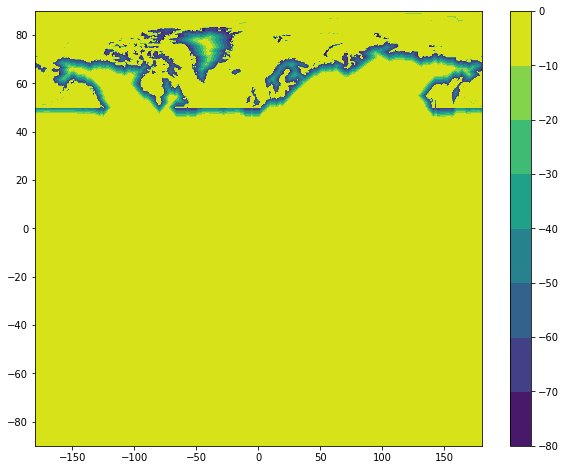

In [159]:
#plot
plt.figure(figsize=(10,8))
plt.contourf(X,Y,dff.T)
plt.colorbar()

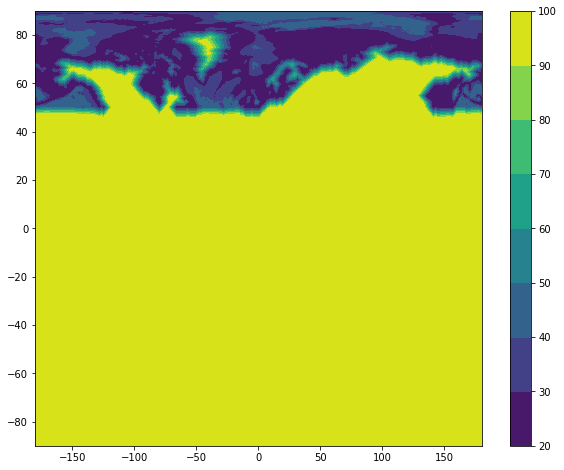

In [161]:
#plot
plt.figure(figsize=(10,8))
plt.contourf(X,Y,tfun.T)
plt.colorbar()

In [162]:
ffun='/Users/brey/Downloads/JIGSAW/out/EARTH-ARCTIC-HFUN.msh'

In [163]:
gf = pd.DataFrame({'hmatx' : xpos.flatten()*np.pi/180, 
'hmaty' : ypos.flatten()*np.pi/180, 
'hmatv' : tfun.flatten()}) 
    

In [164]:
gf.shape

(721801, 3)

In [167]:
gf.head()

,hmatv,hmatx,hmaty
0,100.0,-6.808726e-15,-8.338284e-31
1,100.0,-5.822184e-01,-7.130119e-17
2,100.0,-1.164405e+00,-1.425985e-16
3,100.0,-1.746578e+00,-2.138941e-16
4,100.0,-2.328685e+00,-2.851817e-16


In [169]:
xb['x'] = xb.lon*np.pi/180

In [170]:
yb['y'] = yb.lat*np.pi/180

In [177]:
# write header
with open(ffun,'w') as f:
    f.write('#{}; created by pyPoseidon\n'.format(ffun.split('/')[-1]))
    f.write('MSHID=3;ELLIPSOID-GRID\n')
    f.write('NDIMS=2\n')
    f.write('COORD=1;{}\n'.format(xb.x.size))

In [178]:
with open(ffun, 'a') as f:
    xb.x.to_csv(f, index=False, header=0)

In [179]:
with open(ffun, 'a') as f:
    f.write('COORD=2;{}\n'.format(yb.y.size))

In [180]:
with open(ffun, 'a') as f:
    yb.y.to_csv(f, index=False, header=0)

In [181]:
with open(ffun, 'a') as f:
    f.write('VALUE={};1\n'.format(xb.x.size * yb.y.size)) 

In [182]:
with open(ffun, 'a') as f:
    for i in range(fun.size):
        f.write('{}\n'.format(tfun.flatten()[i]))

In [ ]:
#converted TRANSPOSED, IS THERE A WAY TO FIX IT?
#cfun = fun.flatten().reshape(X.shape).T
#with open(ffun, 'a') as f:
#    for i in range(fun.size):
#        f.write('{}\n'.format(cfun.flatten()[i]))

### test hfun file

In [228]:
ffun

'/Users/brey/Downloads/JIGSAW/out/GLOBAL-HFUN.msh'

In [215]:
coord, nc = pd.read_csv(ffun,header=2,skiprows=1,nrows=0,delimiter='=')
coord, nc

('COORD', '1;1201')

In [216]:
nc0, nc1 = nc.split(';')
nc1 = int(nc1)

In [217]:
#read lon for all boundary nodes
xf = pd.read_csv(ffun,skiprows=4,header=None,nrows=nc1,names=['x'])

In [218]:
coord, nc = pd.read_csv(ffun,header=4,skiprows=nc1,nrows=0,delimiter='=')
coord, nc

('COORD', '2;601')

In [219]:
nc0, nc2 = nc.split(';')
nc2 = int(nc2)

In [220]:
#read lat,depth for boundary nodes
yf = pd.read_csv(ffun,skiprows=5 + nc1,header=None,nrows=nc2,names=['y'])

In [221]:
value, nc = pd.read_csv(ffun,header=4,skiprows=nc1+nc2+1,nrows=0,delimiter='=')
value, nc

('VALUE', '721801;1')

In [222]:
val, val0 = nc.split(';')
val = int(val)

In [223]:
#read 
vs = pd.read_csv(ffun,skiprows=6 + nc1 + nc2,header=None,nrows=val,names=['value'])

In [224]:
X, Y = np.meshgrid(xf,yf)

In [225]:
V = vs.values.reshape(nc1,nc2) #NOTE THE TRANSPOSE

In [226]:
V

array([[100.        , 100.        , 100.        , ...,  31.03659568,
         35.56497514,  36.99112   ],
       [100.        , 100.        , 100.        , ...,  31.08899386,
         35.53877534,  36.99112   ],
       [100.        , 100.        , 100.        , ...,  31.14139379,
         35.51257467,  36.99112   ],
       ...,
       [100.        , 100.        , 100.        , ...,  31.14139379,
         35.61737562,  36.99112   ],
       [100.        , 100.        , 100.        , ...,  31.08899386,
         35.59117494,  36.99112   ],
       [100.        , 100.        , 100.        , ...,  31.03659568,
         35.56497514,  36.99112   ]])

#### plot

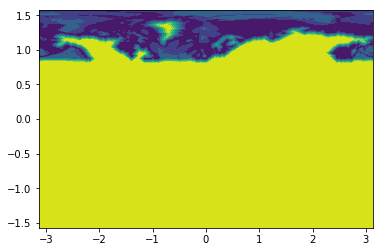

In [194]:
plt.figure()
plt.contourf(X,Y,V.T)


### Compare with the corresponding JIGSAW demo 5 file

In [202]:
jffun = '/Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/out/EARTH-ARCTIC-HFUN.msh'

In [203]:
coord, nc = pd.read_csv(jffun,header=2,skiprows=1,nrows=0,delimiter='=')
coord, nc

('COORD', '1;1201')

In [204]:
nc0, nc1 = nc.split(';')
nc1 = int(nc1)

In [205]:
#read lon for all boundary nodes
jxf = pd.read_csv(jffun,skiprows=4,header=None,nrows=nc1,names=['x'])

In [206]:
coord, nc = pd.read_csv(jffun,header=4,skiprows=nc1,nrows=0,delimiter='=')
coord, nc

('COORD', '2;601')

In [207]:
nc0, nc2 = nc.split(';')
nc2 = int(nc2)

In [208]:
#read lat,depth for boundary nodes
jyf = pd.read_csv(jffun,skiprows=5 + nc1,header=None,nrows=nc2,names=['y'])

In [209]:
value, nc = pd.read_csv(jffun,header=4,skiprows=nc1+nc2+1,nrows=0,delimiter='=')
value, nc

('VALUE', '721801;1')

In [210]:
val, val0 = nc.split(';')
val = int(val)

In [211]:
#read 
jvs = pd.read_csv(jffun,skiprows=6 + nc1 + nc2,header=None,nrows=val,names=['value'])

In [212]:
jX, jY = np.meshgrid(jxf,jyf)

In [213]:
jV = vs.values.reshape(nc1,nc2) #NOTE THE TRANSPOSE

In [214]:
jV

array([[100.        , 100.        , 100.        , ...,  31.03659568,
         35.56497514,  36.99112   ],
       [100.        , 100.        , 100.        , ...,  31.08899386,
         35.53877534,  36.99112   ],
       [100.        , 100.        , 100.        , ...,  31.14139379,
         35.51257467,  36.99112   ],
       ...,
       [100.        , 100.        , 100.        , ...,  31.14139379,
         35.61737562,  36.99112   ],
       [100.        , 100.        , 100.        , ...,  31.08899386,
         35.59117494,  36.99112   ],
       [100.        , 100.        , 100.        , ...,  31.03659568,
         35.56497514,  36.99112   ]])

In [227]:
np.array_equal(V,jV)

True

## jig file

In [229]:
jig='/Users/brey/Downloads/JIGSAW/EARTH-ARCTIC.jig'

In [230]:
fmsh = '/Users/brey/Downloads/JIGSAW/out/EARTH-ARCTIC-MESH.msh'

In [231]:
with open(jig,'w') as f:
    f.write('#{}; created by pyPoseidon\n'.format(jig.split('/')[-1]))
    f.write('GEOM_FILE ={}\n'.format(fgeo))
    f.write('MESH_FILE ={}\n'.format(fmsh))
    f.write('HFUN_FILE ={}\n'.format(ffun))
    f.write('HFUN_SCAL = ABSOLUTE\n')
    f.write('HFUN_HMAX = 150\n')
    f.write('HFUN_HMIN = 0.0\n')
    f.write('MESH_DIMS = 2\n')
    f.write('OPTM_QLIM=0.9375\n')
    f.write('VERBOSITY = 1')

## Execute jigsaw

In [232]:
! /Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/bin/MAC-64/jigsaw64r /Users/brey/Downloads/JIGSAW/EARTH-ARCTIC.jig

 
#------------------------------------------------------------
#
#   ,o, ,o,       /                                 
#    `   `  e88~88e  d88~\   /~~~8e Y88b    e    / 
#   888 888 88   88 C888         88b Y88b  d8b  /   
#   888 888 "8b_d8"  Y88b   e88~-888  Y888/Y88b/  
#   888 888  /        888D C88   888   Y8/  Y8/     
#   88P 888 Cb      \_88P   "8b_-888    Y    Y    
# \_8"       Y8""8D                             
#
#------------------------------------------------------------
# JIGSAW: an unstructured mesh generation package.  
#------------------------------------------------------------
 
  JIGSAW VERSION 0.9.5

  Reading CFG. file...

  CFG. data summary...

  GEOM_FILE = /Users/brey/Downloads/JIGSAW/geo/Global-GEOM.msh 
  MESH_FILE = /Users/brey/Downloads/JIGSAW/out/Global.msh 
  HFUN_FILE = /Users/brey/Downloads/JIGSAW/out/GLOBAL-HFUN.msh 

  GEOM_SEED = 8 
  GEOM_PHI1 = 6.00e+01 
  GEOM_PHI2 = 6.00e+01 
  GEOM_ETA1 = 4.50e+01 
  GEOM_ETA2 = 4.50e+01 
  GEOM_FEAT = FALS